# Running the DenseNet121

In [100]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, ZeroPadding2D,\
    Dropout, Input
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, \
    f1_score, confusion_matrix
from keras.applications.densenet import DenseNet121
import sys
import os
os.chdir('c:/users/nicolas/documents/data/prostate/zoom-60')
from glob import glob

In [71]:
# initializing lists and lists of lists
normal, anormal = [], []
cat = [normal, anormal]
str_cat = ['normal', 'anormal']

In [72]:
# importing images
ix, ix_files = 0, 0

for ix, item in enumerate(cat):
    files = glob('{}/*jpg'.format(str_cat[ix]))
    for file in files: 
        ix_files += 1        
        if ix_files%10 == 0:
            print('%i images uploaded.'%(ix_files))
        image = plt.imread(file)
        item.append(image)
        
total_len = sum(len(c) for c in cat)
            
if ix_files > total_len-20:
        print()
        print('%i images successfully uploaded.'%(total_len))
        
print(); print('\n'.join(['Length of category <{}> is {}'.format(str_cat[i], 
                                len(cat[i])) for i in range(2)]))

10 images uploaded.
20 images uploaded.

26 images successfully uploaded.

Length of category <normal> is 13
Length of category <anormal> is 13


In [73]:
# assert to be notified of any mistake
assert np.array(cat[0]).shape == (13, 1920, 2448, 3), 'There\'s something wrong with the shapes'

In [74]:
# getting shape
rand = np.random.randint(0, 2)
height, width, channels = cat[rand][np.random.randint(len(cat[rand]))].shape
print(f'We have {height} pixels of height, {width} pixels of width, and {channels} channels.')

We have 1920 pixels of height, 2448 pixels of width, and 3 channels.


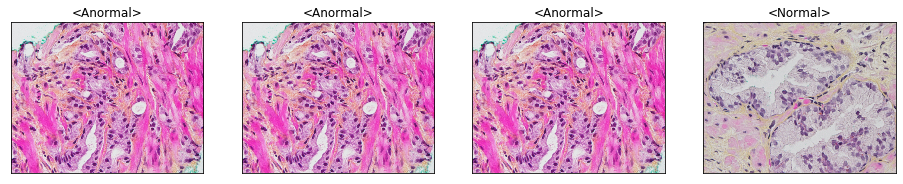

In [75]:
# example pictures
fig = plt.figure(figsize=(20, 20))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(0, 2)
    ax = plt.imshow(cat[rand][np.random.randint(len(cat[rand]))])
    plt.title('<{}>'.format(str_cat[rand].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

In [76]:
# resize to 1/4th
ix = 0
fraction = 15
res_normal, res_anormal = [], []
res_cat = [res_normal, res_anormal]
new_height = int(height/fraction)
new_width = int(width/fraction)
for inx, item in enumerate(cat):
    for elem in item:
        image = Image.fromarray(elem)
        ix+=1
        if ix % 5 == 0:
            print(str(ix), 'images iterated for resizing')
        img=image.resize((new_width, new_height)) #.save('resized/{}'.format(os.path.splitext(elem)[0] + '.png'))
        res_cat[inx].append(np.array(img))
        
print('\n%i images successfully resized.'%(total_len))

5 images iterated for resizing
10 images iterated for resizing
15 images iterated for resizing
20 images iterated for resizing
25 images iterated for resizing

26 images successfully resized.


In [77]:
# function to reshape to a square
def crop(img):
    if img.shape[0]<img.shape[1]: # it means horizontal photo
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

In [78]:
# apply square function
sq_normal, sq_anormal = [], []
sq_cat = [sq_normal, sq_anormal]
square_array = []
for ix, res in enumerate(res_cat):
    for elem in res:
        to_numpy = np.array(elem)
        sq_cat[ix].append(crop(to_numpy))

In [79]:
# assert to be notified of any mistake
n_row, n_col, chans = sq_cat[0][0].shape
assert np.array(sq_normal).shape == (13, n_row, n_col, chans), 'There\'s something wrong with the shapes'
assert np.array(sq_anormal).shape == (13, n_row, n_col, chans), 'There\'s something wrong with the shapes'

In [81]:
# function to rotate images
def random_rotate(img):
    
    return np.rot90(img, np.random.randint(0, 4))

In [93]:
# putting all the edited images in a new list/array
rot_normal, rot_anormal = np.empty((0, n_row, n_col, chans), np.float32),\
                    np.empty((0, n_row, n_col, chans), np.float32)
rot_cat = [rot_normal, rot_anormal]
rotated_array = []
for ix, sq in enumerate(sq_cat):
    for elem in sq:
        to_numpy = np.array(elem)
        array = random_rotate(to_numpy)[np.newaxis, :]
        rot_cat[ix] = np.append(rot_cat[ix], array, axis=0)
rot_normal, rot_anormal = rot_cat[0], rot_cat[1]

In [94]:
# get shape info
print(np.array(rot_normal).shape)

(13, 128, 128, 3)


In [95]:
# assert all shapes are as expect
assert np.array(rot_normal).shape == (13, n_row, n_col, chans), 'There\'s something wrong with the shapes'
assert np.array(rot_anormal).shape == (13, n_row, n_col, chans), 'There\'s something wrong with the shapes'

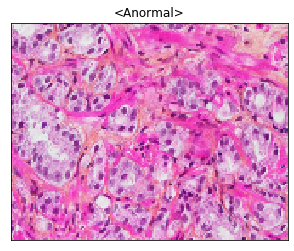

In [96]:
# full sized example of resized and rotated pictures
rand = np.random.randint(0, 2)
ax = plt.imshow(res_cat[rand][np.random.randint(len(res_cat[rand]))])
plt.title('<{}>'.format(str_cat[rand].capitalize()))
yticks = plt.xticks([])
yticks = plt.yticks([])

In [97]:
# # separating predictors and targets
X = np.vstack(rot_cat).astype(np.float32)
normal_target = [0 for i in range(rot_normal.shape[0])]
anormal_target = [1 for i in range(rot_normal.shape[0])]
y = np.concatenate([normal_target, anormal_target]).astype(np.float32)

In [98]:
# separating predictors and targets
# X = np.vstack(res_cat).astype(np.float32)
# normal_target = [0 for i in range(len(res_normal))]
# anormal_target = [1 for i in range(len(res_normal))]
# y = np.concatenate([normal_target, anormal_target]).astype(np.float32)

In [109]:
# clearing globals
normal, anormal = [], []
cat = [normal, anormal]
res_normal, res_anormal = [], []
res_cat = [res_normal, res_anormal]
sq_normal, sq_anormal = [], []
sq_cat = [sq_normal, sq_anormal]
square_array = []

In [111]:
# # verifying shape
# assert X.shape[1:] == (new_height, new_width, channels), 'The input shape does not \
# correspond to the desired shape.'

In [112]:
# rescaling the input
X = np.divide(X, 255)

In [113]:
# changing the format of the target
y = to_categorical(y)

In [114]:
# assert that classes are balanced
assert all(y.sum(axis=0) % 13 == 0) 

In [24]:
# cross-validation
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=2e-1)

In [25]:
# getting the shape of each subset
train_size, test_size = xtrain.shape[0], xtest.shape[0]
print(f'The train size is {train_size} samples and the test size is {test_size} samples.')

The train size is 20 samples and the test size is 6 samples.


In [115]:
# getting the input shape
input_shape = (X.shape[1], X.shape[2], X.shape[3])
print(X.shape)

(26, 128, 128, 3)


In [27]:
# creating an input tensor for the neural net
inputs = Input(shape=(X.shape[1], X.shape[2], X.shape[3]))

In [29]:
# building the model

x = DenseNet121(include_top=False, weights='imagenet', 
                        input_tensor=None, input_shape=xtrain.shape[1:], pooling=None)(inputs)

x = Flatten()(x)
x = Dropout(0.5)(x)

x = Dense(2048, activation='relu')(x) 
x = Dropout(0.5)(x)

x = Dense(2, activation='sigmoid', name='output')(x)

In [30]:
# predictions
predictions = x

In [31]:
# finalizing the model
model = Model(inputs=inputs, outputs=predictions)

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 163, 3)       0         
_________________________________________________________________
densenet121 (Model)          (None, 4, 5, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20480)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              20972544  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 2)                 2050      
Total para

In [34]:
# compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
# training the model
hist = model.fit(xtrain, ytrain,
                 epochs=15,
                 batch_size=1,
                 validation_data=[xtest, ytest])

Train on 20 samples, validate on 6 samples
Epoch 1/15
20/20 [==============================] - 30s 2s/step - loss: 7.9936 - acc: 0.3500 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/15
20/20 [==============================] - 4s 203ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/15
20/20 [==============================] - 4s 202ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/15
20/20 [==============================] - 4s 203ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/15
20/20 [==============================] - 4s 202ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/15
20/20 [==============================] - 4s 203ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/15
20/20 [==============================] - 4s 204ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/15
20/20 [=================

In [36]:
# floor accuracy
pct = int(y[:,0].sum()/len(y)*100)
print('Bottom accuracy:', str(pct)+'% or', str(100-pct) + '%.')

Bottom accuracy: 50% or 50%.


In [38]:
# making predictions on the test set
ypred = model.predict(xtest)

In [39]:
# the predicted probabilities
ypred

array([[0.0000000e+00, 0.0000000e+00],
       [1.0454483e-36, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00]], dtype=float32)

Notice here that the neural network doesn't learn anything from the data. It is in fact not even _thinking_.

In [40]:
# the predictions
[str_cat[i] for i in np.argmax(ypred, axis=1)]

['normal', 'normal', 'normal', 'normal', 'normal', 'normal']

With this strategy, it doesn't seem like a convolutional neural net based on the DenseNet121 can accurately detect prostate cancer. This is still early in the project. I will need to consult the physicians and demand more pictures to train the model on.